### Script to simulate electrophysiological timeseries ###

In [1]:
### Import sim functions
import numpy as np
import pandas as pd

from scipy.linalg import norm
from itertools import repeat

from neurodsp.sim import sim_powerlaw
from neurodsp.utils import set_random_seed

# Import function to compute power spectra
from neurodsp.spectral import compute_spectrum

# Import utilities for plotting data
from neurodsp.utils import create_times
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.plts.time_series import plot_time_series

In [5]:

def sim_peak_oscillation(sig_ap, fs, freq, bw, height):
    """Simulate a signal with an aperiodic component and a specific oscillation peak.
    Parameters
    ----------
    sig_ap : 1d array
        The timeseries of the aperiodic component.
    fs : float
        Sampling rate of ``sig_ap``.
    freq : float
        Central frequency for the gaussian peak in Hz.
    bw : float
        Bandwidth, or standard deviation, of gaussian peak in Hz.
    height : float
        Relative height of the gaussian peak at the central frequency ``freq``.
        Units of log10(power), over the aperiodic component.
    Returns
    -------
    sig : 1d array
        Time series with desired power spectrum.
    Notes
    -----
    - This function creates a time series whose power spectrum consists of an aperiodic component
    and a gaussian peak at ``freq`` with standard deviation ``bw`` and relative ``height``.
    - The periodic component of the signal will be sinusoidal.
    Examples
    --------
    Simulate a signal with aperiodic exponent of -2 & oscillation central frequency of 20 Hz:
    >>> from neurodsp.sim import sim_powerlaw
    >>> fs = 500
    >>> sig_ap = sim_powerlaw(n_seconds=10, fs=fs)
    >>> sig = sim_peak_oscillation(sig_ap, fs=fs, freq=20, bw=5, height=7)
    """

    sig_len = len(sig_ap)
    times = create_times(sig_len / fs, fs)
    
    freq1=freq[0]
    freq2=freq[1]
    bw1=bw[0]
    bw2=bw[1]
    height1=height[0]
    height2=height[1]

    # Construct the aperiodic component and compute its Fourier transform
    # Only use the first half of the frequencies from the FFT since the signal is real
    sig_ap_hat = np.fft.fft(sig_ap)[0:(sig_len // 2 + 1)]

    # Create the range of frequencies that appear in the power spectrum since these
    # will be the frequencies in the cosines we sum below
    freqs = np.linspace(0, fs / 2, num=sig_len // 2 + 1, endpoint=True)

    # Construct the array of relative heights above the aperiodic power spectrum
    rel_heights1 = np.array([height1 * np.exp(-(lin_freq - freq1) ** 2 / (2 * bw1 ** 2)) \
        for lin_freq in freqs])
        
    # Construct the array of relative heights above the aperiodic power spectrum
    rel_heights2 = np.array([height2 * np.exp(-(lin_freq - freq2) ** 2 / (2 * bw2 ** 2)) \
            for lin_freq in freqs])
        
    rel_heights= rel_heights1+rel_heights2

    # Build an array of the sum of squares of the cosines to use in the amplitude calculation
    cosine_norms = np.array([norm(np.cos(2 * np.pi * lin_freq * times), 2) ** 2 \
        for lin_freq in freqs])

    # Build an array of the amplitude coefficients
    cosine_coeffs = np.array([\
        (-np.real(sig_ap_hat[ell]) + np.sqrt(np.real(sig_ap_hat[ell]) ** 2 + \
        (10 ** rel_heights[ell] - 1) * np.abs(sig_ap_hat[ell]) ** 2)) / cosine_norms[ell] \
        for ell in range(cosine_norms.shape[0])])

    # Add cosines with the respective coefficients and with a random phase shift for each one
    sig_periodic = np.sum(np.array([cosine_coeffs[ell] * \
                                   np.cos(2 * np.pi * freqs[ell] * times + \
                                          2 * np.pi * np.random.rand()) \
                          for ell in range(cosine_norms.shape[0])]), axis=0)

    sig = sig_ap + sig_periodic

    return sig

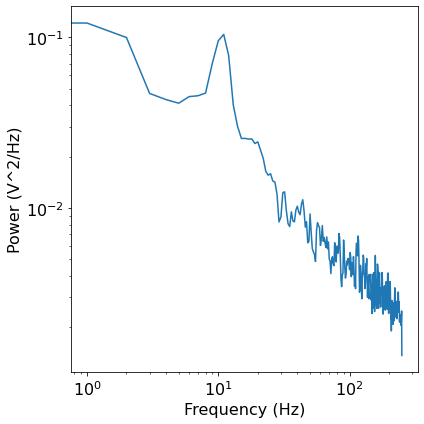

In [10]:
# Set some general settings, to be used across all simulations
fs = 500 # sampling rate
n_seconds = 60 # length of recording 
times = create_times(n_seconds, fs)

alpha_freq=10
alpha_bw=2
alpha_height=0.7

beta_freq=19
beta_bw=5
beta_height=0.4

expon= -0.7
# Simulate aperiodic element
signal = sim_powerlaw(n_seconds, fs, expon)
# Simulate periodic element
signal = sim_peak_oscillation(signal, fs, [alpha_freq, beta_freq], [alpha_bw, beta_bw], [alpha_height, beta_height])
freqs, psd = compute_spectrum(signal, fs)
plot_power_spectra(freqs, psd)

In [19]:

parameters_used=pd.DataFrame({'SubID' : [], 'peak_freq' : [], 'peak_band' : [], 'peak_height' : [], 'aper_expon' : [], 'group': []})

expons= [-0.7, -0.8, -0.9, -1.0, -1.1, -1.2, -1.3, -1.4, -1.5]

for j in expons:
    for i in range(10):
        # Set some general settings, to be used across all simulations
        fs = 500 # sampling rate
        n_seconds = 150 # length of recording 

        alpha_freq=10
        alpha_bw=2
        alpha_height=0.7

        beta_freq=19
        beta_bw=5
        beta_height=0.4

        expon= j
        # Simulate aperiodic element
        signal = sim_powerlaw(n_seconds, fs, expon)
        # Simulate periodic element
        signal = sim_peak_oscillation(signal, fs, [alpha_freq, beta_freq], [alpha_bw, beta_bw], [alpha_height, beta_height])
        np.savetxt('./data/sim' + '_expon_' + str(-1*j) + '_simulation_ No_' + str(i) + '.csv', signal, delimiter=",")
        parameters_used= parameters_used.append({'SubID': i, 'peak_freq':freq, 'peak_band':bw, 'peak_height':height, 'aper_expon': expon, 'group': 1}, ignore_index=True)



/var/folders/rx/rbbgxxy13dg0_5y69m3b81_r0000gn/T/ipykernel_90016/116568526.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters_used= parameters_used.append({'SubID': i, 'peak_freq':freq, 'peak_band':bw, 'peak_height':height, 'aper_expon': expon, 'group': 1}, ignore_index=True)
/var/folders/rx/rbbgxxy13dg0_5y69m3b81_r0000gn/T/ipykernel_90016/116568526.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters_used= parameters_used.append({'SubID': i, 'peak_freq':freq, 'peak_band':bw, 'peak_height':height, 'aper_expon': expon, 'group': 1}, ignore_index=True)
/var/folders/rx/rbbgxxy13dg0_5y69m3b81_r0000gn/T/ipykernel_90016/116568526.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters_used= paramete

/var/folders/rx/rbbgxxy13dg0_5y69m3b81_r0000gn/T/ipykernel_90016/116568526.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters_used= parameters_used.append({'SubID': i, 'peak_freq':freq, 'peak_band':bw, 'peak_height':height, 'aper_expon': expon, 'group': 1}, ignore_index=True)
/var/folders/rx/rbbgxxy13dg0_5y69m3b81_r0000gn/T/ipykernel_90016/116568526.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters_used= parameters_used.append({'SubID': i, 'peak_freq':freq, 'peak_band':bw, 'peak_height':height, 'aper_expon': expon, 'group': 1}, ignore_index=True)
/var/folders/rx/rbbgxxy13dg0_5y69m3b81_r0000gn/T/ipykernel_90016/116568526.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters_used= paramete

/var/folders/rx/rbbgxxy13dg0_5y69m3b81_r0000gn/T/ipykernel_90016/116568526.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters_used= parameters_used.append({'SubID': i, 'peak_freq':freq, 'peak_band':bw, 'peak_height':height, 'aper_expon': expon, 'group': 1}, ignore_index=True)
/var/folders/rx/rbbgxxy13dg0_5y69m3b81_r0000gn/T/ipykernel_90016/116568526.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters_used= parameters_used.append({'SubID': i, 'peak_freq':freq, 'peak_band':bw, 'peak_height':height, 'aper_expon': expon, 'group': 1}, ignore_index=True)
/var/folders/rx/rbbgxxy13dg0_5y69m3b81_r0000gn/T/ipykernel_90016/116568526.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters_used= paramete

/var/folders/rx/rbbgxxy13dg0_5y69m3b81_r0000gn/T/ipykernel_90016/116568526.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters_used= parameters_used.append({'SubID': i, 'peak_freq':freq, 'peak_band':bw, 'peak_height':height, 'aper_expon': expon, 'group': 1}, ignore_index=True)
/var/folders/rx/rbbgxxy13dg0_5y69m3b81_r0000gn/T/ipykernel_90016/116568526.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters_used= parameters_used.append({'SubID': i, 'peak_freq':freq, 'peak_band':bw, 'peak_height':height, 'aper_expon': expon, 'group': 1}, ignore_index=True)
/var/folders/rx/rbbgxxy13dg0_5y69m3b81_r0000gn/T/ipykernel_90016/116568526.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters_used= paramete

/var/folders/rx/rbbgxxy13dg0_5y69m3b81_r0000gn/T/ipykernel_90016/116568526.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters_used= parameters_used.append({'SubID': i, 'peak_freq':freq, 'peak_band':bw, 'peak_height':height, 'aper_expon': expon, 'group': 1}, ignore_index=True)
/var/folders/rx/rbbgxxy13dg0_5y69m3b81_r0000gn/T/ipykernel_90016/116568526.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters_used= parameters_used.append({'SubID': i, 'peak_freq':freq, 'peak_band':bw, 'peak_height':height, 'aper_expon': expon, 'group': 1}, ignore_index=True)
